In [1]:
environment_path="/home/aacedo/Documents/SAIG/Codes/JUDI.jl"
examples_path = "/home/aacedo/Documents/SAIG/Codes/JUDI.jl/examples/notebooks/";

cd(environment_path)
using Pkg
Pkg.activate(environment_path)
cd(examples_path)



using JUDI


using DSP
using SeisMakie; 
using CairoMakie;
using FFTW
using Statistics
#using LinearAlgebra
using DelimitedFiles
using HDF5
using Base.Threads

using Random

Random.seed!(5678)
println("Number of threads: ", nthreads())

  Activating project at `~/Documents/SAIG/Codes/JUDI.jl`


Number of threads: 32


## Set up the physical problem for modeling: 

### 1) GRID



Define the main grid for the forward modeling. One starts by defining the parameters for a cartesian grid:

In [2]:
shape = (201, 201) # Number of gridpoints nx, nz
spacing = (10.0, 10.0) #spacing meters here
origin = (0.0, 0.0) # origin in meters

(0.0, 0.0)

In [3]:
vp=readdlm("Synthetic_Marmousi_TimeLapse_VelocityModel_T0.txt");
shape=size(vp);
spacing=(10.0, 10.0);
origin = (0.0, 0.0) # origin in meters
VP = PhysicalParameter(vp, spacing, origin)';

In [ ]:
m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o");
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);




#imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0));
#xlabel("Lateral position [km]");
#ylabel("Depth [km]");

In [33]:
# Define the velocity (in km/sec=m/ms)
vp = 1.5f0 * ones(Float32, shape)
vp[:, 66:end] .= 2.0f0
vp[:, 134:end] .= 2.5f0
# Create a physical parameter
VP = PhysicalParameter(vp, spacing, origin)';

Adopting a cartesian dimension ordering for generality (X, Z) in 2D and (X, Y, Z) in 3D, we plot the transpose of the velocity for proper visualization:

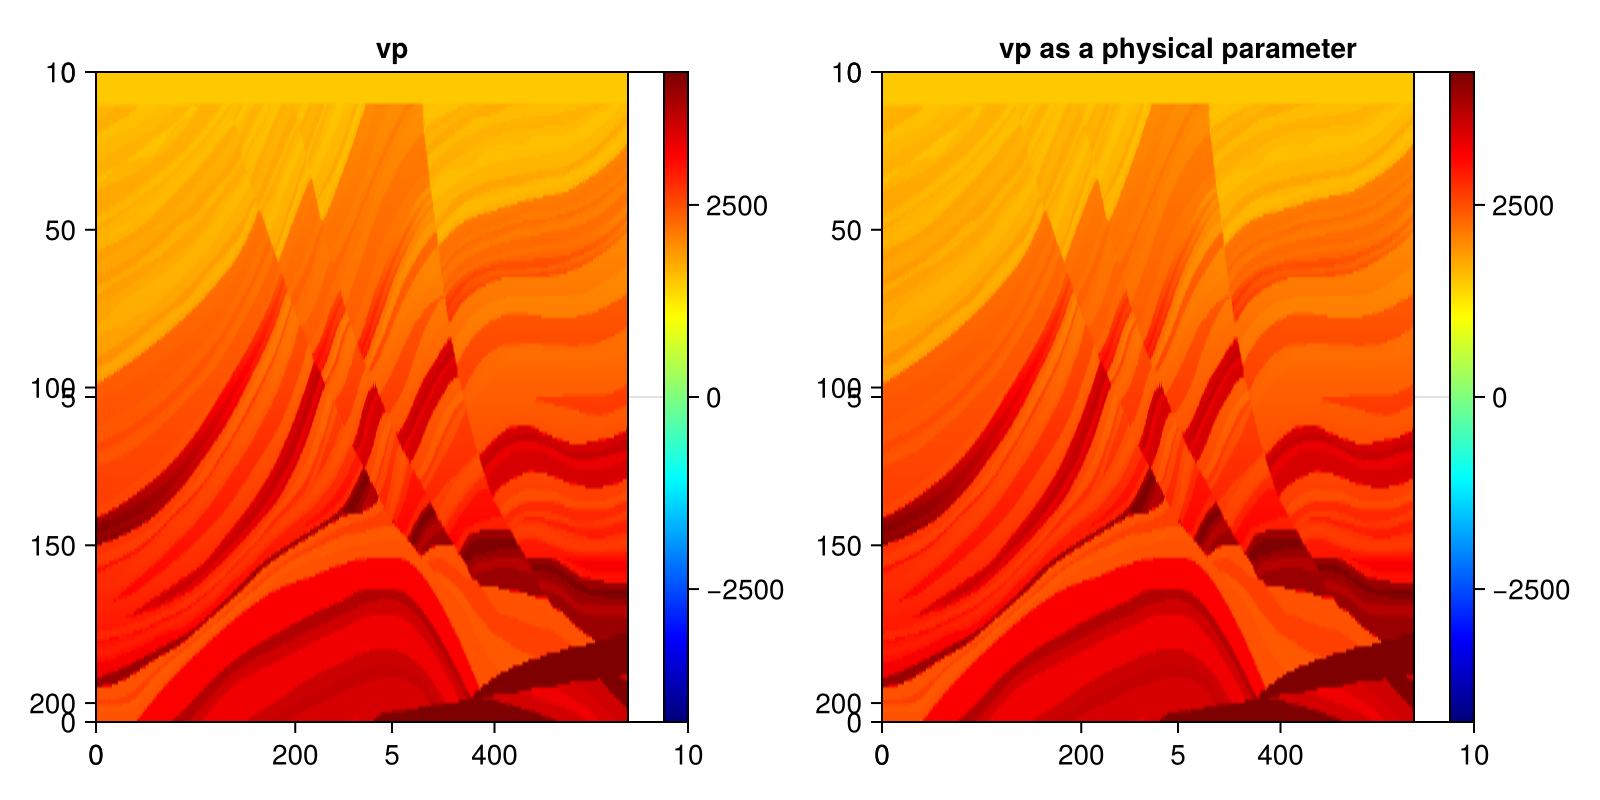

In [4]:
using CairoMakie

# Create a figure with 1 row, 2 columns
fig = Figure(size = (800, 400))

# First subplot
ax1 = Axis(fig[1, 1],
    title = "vp"
)

_, ax1 = seisPlotTX(vp,
cmap="jet", fig=fig[1,1])

# Second subplot
ax2 = Axis(fig[1, 2],
    title = "vp as a physical parameter"
)


_, ax2 = seisPlotTX(VP',
cmap="jet", fig=fig[1,2])




fig


## Model

Wrap everything into a structure model. JUDI then provide a `Model` structure that wraps multiple physical parameters toghether. A `Model` accept currently only accept standard Array as an input (**to be fixed #1**)

In [5]:
model = Model(shape, spacing, origin, 1f0./vp.^2f0)

Model (n=(206, 534), d=(10.0f0, 10.0f0), o=(0.0f0, 0.0f0)) with parameters (:m, :rho)


## Acquisition Geometry


First, we need is an acquisiton geometry. In JUDI there is two ways to create a Geometry:

- By hand, as we will show here
- From a SEGY file

We create a split-spread geomtry with sources at the top and receivers at the ocean bottom (top of second layer).

**Note**:
- JUDI currently expects all three coordinates to be inputed to setup a Geometry in 2D as well. This will be fixed in a later version of JUDI.

In [6]:
# Sources position
nsrc = 11
xsrc = range(0f0, (shape[1] -1)*spacing[1], length=nsrc)
ysrc = 0f0 .* xsrc # this a 2D case so we set y to zero
zsrc = 12.5f0*ones(Float32, nsrc);

In [7]:
xsrc, ysrc, zsrc = convertToCell.([xsrc, ysrc, zsrc]);

In [8]:
# OBN position
nrec = 101
xrec = range(0f0, (shape[1] -1)*spacing[1], length=nrec)
yrec = 0f0 # this a 2D case so we set y to zero. This can be a single number for receivers
zrec = (10*spacing[1])*ones(Float32, nrec);

In [9]:
record_time = 4000f0 # Recording time in ms (since we have m/ms for the velocity)
sampling_rate = 4f0; # Let's use a standard 4ms sampling rate

In [10]:
src_geom = Geometry(xsrc, ysrc, zsrc; dt=sampling_rate, t=record_time)
# For the receiver geometry, we specify the number of source to tell JUDI to use the same receiver position for all sources
rec_geom = Geometry(xrec, yrec, zrec, dt=sampling_rate, t=record_time, nsrc=nsrc);

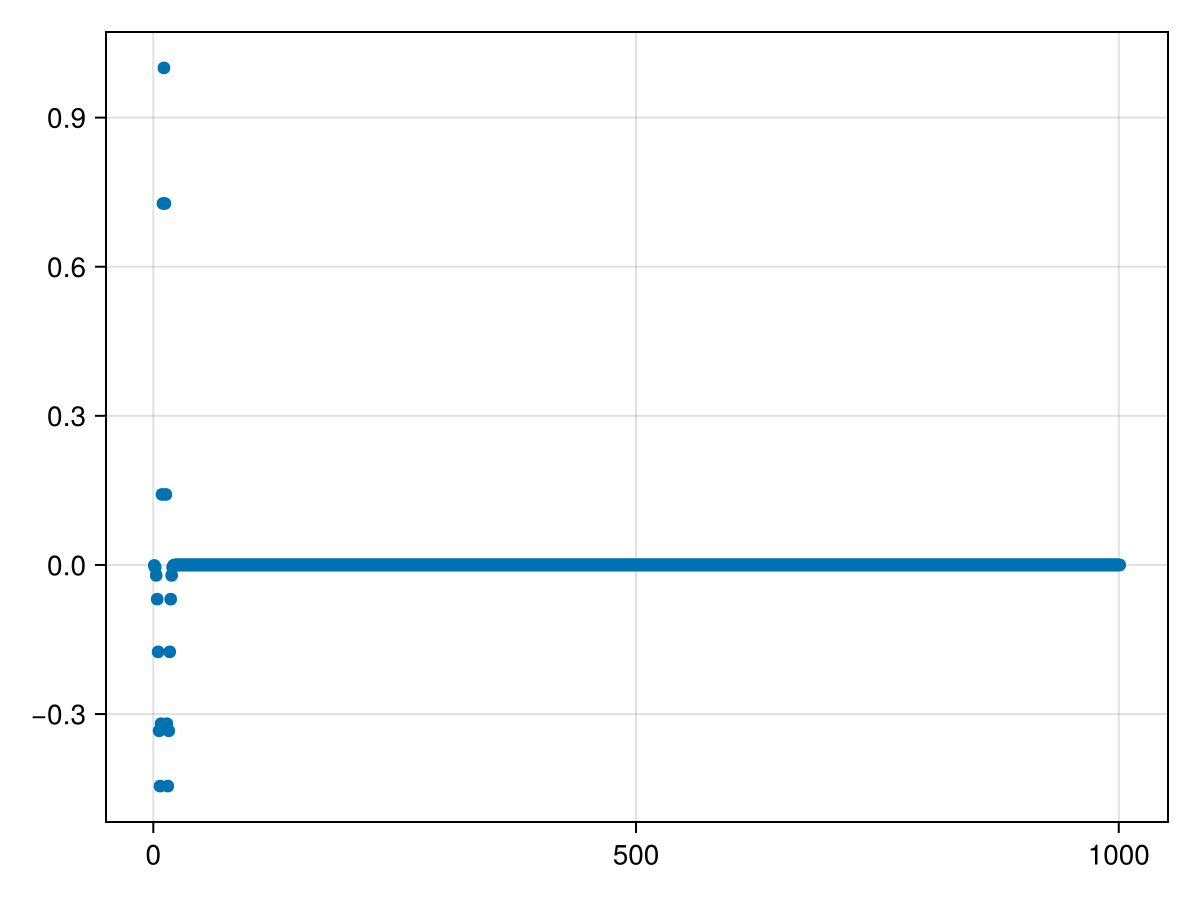

In [11]:
f0 = 0.025 # Since we use ms, the frequency is in KHz
wavelet = ricker_wavelet(record_time, sampling_rate, f0);


plot(vec(wavelet))

In [12]:
q = judiVector(src_geom, wavelet) #source geometry.
Pr = judiProjection(rec_geom) # receiver interpolation
Ps = judiProjection(src_geom) # Source interpolationPr = judiProjection(rec_geom) # receiver interpolation
Ps = judiProjection(src_geom) # Source interpolation
Ainv = judiModeling(model) # Inverse of the disrete ewave equation.
Ainv = judiModeling(model) # Inverse of the disrete ewave equation.

JUDI forward{Float32} propagator (x * z * time) -> (x * z * time)


In [ ]:
d_obs = Pr * Ainv * Ps' * q

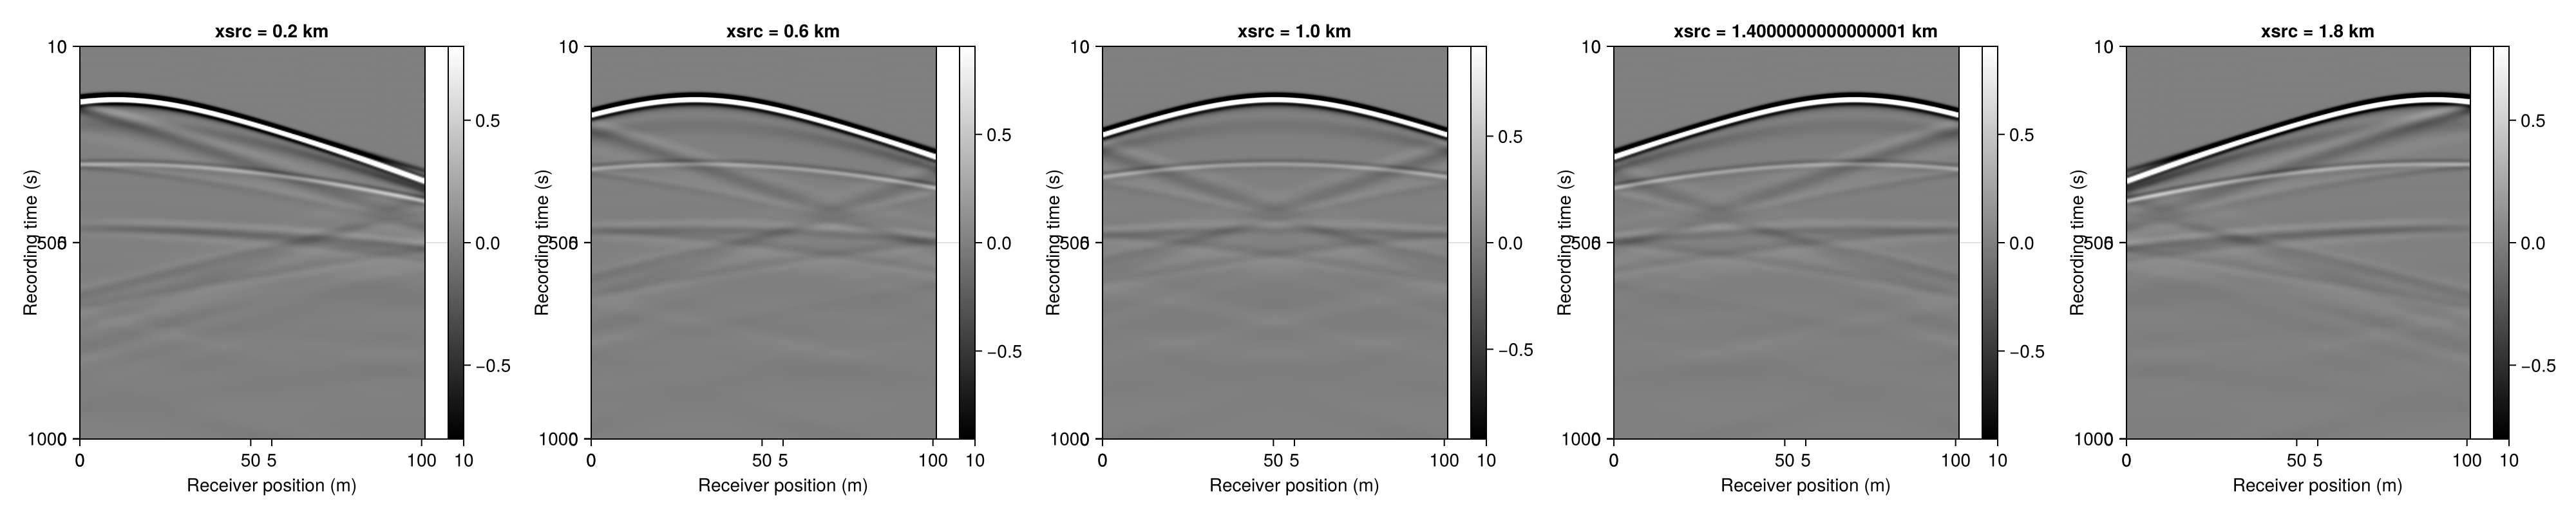

In [50]:
using CairoMakie

# Example dummy data (replace with your real data)
#record_time = 2.0  # seconds
#xrec = LinRange(0, 1000, 100)
#xsrc = [(i*200.0,) for i in 1:10]  # Dummy xsrc points
#d_obs_data = [randn(100, 100) for _ in 1:10]  # Random seismic shots

# Extent for plotting (receiver x-axis, time y-axis)
xlims = (xrec[1], xrec[end])
ylims = (1e-3 * record_time, 0.0)  # Flipped for time

# Create a figure with 1 row and 5 columns
fig = Figure(size = (2000, 400))

for i in 1:5
    ax = Axis(fig[1, i],
        xlabel = "Receiver position (m)",
        ylabel = "Recording time (s)",
        title = "xsrc = $(1e-3 * xsrc[2*i][1]) km")



    _, ax = seisPlotTX(d_obs.data[2*i],
                     cmap="gist_gray", fig=fig[1,i])


    # Set the limits manually
   # xlimits!(ax, xlims...)
    #ylimits!(ax, ylims...)
end

fig
